<a href="https://colab.research.google.com/github/MoronSlayer/Deep-Learning-Projects/blob/learner/KNN_CUDA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
%matplotlib inline

In [2]:
!pip install pykeops

In [4]:
import time

import numpy as np
import torch
from matplotlib import pyplot as plt

from pykeops.torch import LazyTensor

use_cuda = torch.cuda.is_available()
dtype = torch.cuda.FloatTensor if use_cuda else torch.FloatTensor


[KeOps] Compiling cuda jit compiler engine ... OK
[pyKeOps] Compiling nvrtc binder for python ... OK


In [5]:
N, D = 10000 if use_cuda else 1000, 2  # Number of samples, dimension
x = torch.rand(N, D).type(dtype)  # Random samples on the unit square

# Random-ish class labels:
def fth(x):
    return 3 * x * (x - 0.5) * (x - 1) + x


cl = x[:, 1] + 0.1 * torch.randn(N).type(dtype) < fth(x[:, 0])

In [7]:
M = 1000 if use_cuda else 100
tmp = torch.linspace(0, 1, M).type(dtype)
g2, g1 = torch.meshgrid(tmp, tmp)
g = torch.cat((g1.contiguous().view(-1, 1), g2.contiguous().view(-1, 1)), dim=1)

/usr/local/lib/python3.7/dist-packages/torch/functional.py:478: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2894.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


[KeOps] Generating code for formula ArgKMin_Reduction(Sum((Var(0,2,0)-Var(1,2,1))**2),0) ... OK
[KeOps] Generating code for formula ArgKMin_Reduction(Sum((Var(0,2,0)-Var(1,2,1))**2),0) ... OK
[KeOps] Generating code for formula ArgKMin_Reduction(Sum((Var(0,2,0)-Var(1,2,1))**2),0) ... OK
[KeOps] Generating code for formula ArgKMin_Reduction(Sum((Var(0,2,0)-Var(1,2,1))**2),0) ... OK
[KeOps] Generating code for formula ArgKMin_Reduction(Sum((Var(0,2,0)-Var(1,2,1))**2),0) ... OK


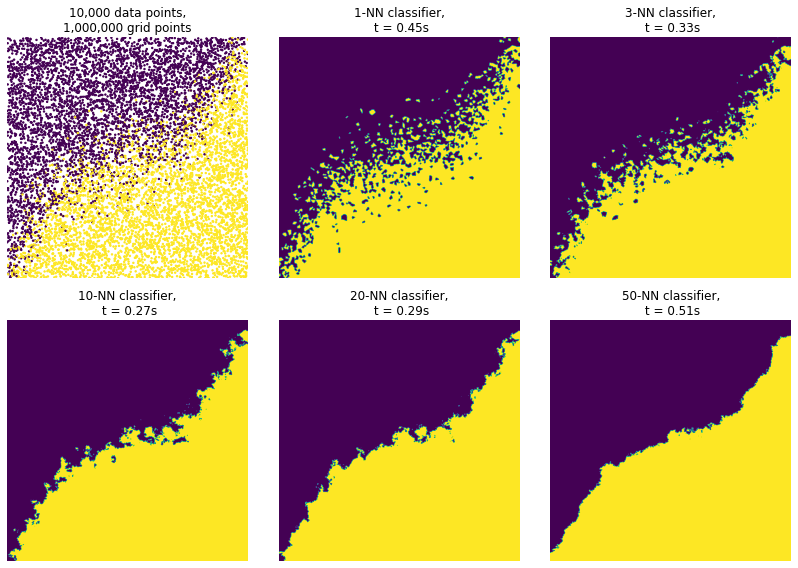

In [8]:
plt.figure(figsize=(12, 8))
plt.subplot(2, 3, 1)
plt.scatter(x.cpu()[:, 0], x.cpu()[:, 1], c=cl.cpu(), s=2)
plt.imshow(np.ones((2, 2)), extent=(0, 1, 0, 1), alpha=0)
plt.axis("off")
plt.axis([0, 1, 0, 1])
plt.title("{:,} data points,\n{:,} grid points".format(N, M * M))

for (i, K) in enumerate((1, 3, 10, 20, 50)):

    start = time.time()  # Benchmark:

    G_i = LazyTensor(g[:, None, :])  # (M**2, 1, 2)
    X_j = LazyTensor(x[None, :, :])  # (1, N, 2)
    D_ij = ((G_i - X_j) ** 2).sum(-1)  # (M**2, N) symbolic matrix of squared distances
    indKNN = D_ij.argKmin(K, dim=1)  # Grid <-> Samples, (M**2, K) integer tensor

    clg = cl[indKNN].float().mean(1) > 0.5  # Classify the Grid points
    end = time.time()

    plt.subplot(2, 3, i + 2)  # Fancy display:
    clg = clg.view(M, M)
    plt.imshow(clg.cpu(), extent=(0, 1, 0, 1), origin="lower")
    plt.axis("off")
    plt.axis([0, 1, 0, 1])
    plt.tight_layout()
    plt.title("{}-NN classifier,\n t = {:.2f}s".format(K, end - start))

plt.show()